# Imports

In [ ]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from torch import tensor
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
import trainer as trainer
from data import get_data
from models import get_model
from tester import tester
from loss import *

In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Load Data 

In [3]:
dataset_name = 'Visium_Mouse_Olfactory_Bulb'

## Genes-Spots Expression Values 

In [4]:
obj = StlearnLoader().load_local_visum(path=path.join('/', 'data', dataset_name),
                                      count_file='filtered_feature_bc_matrix.h5')
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')
obj

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285


AnnData object with n_obs × n_vars = 1185 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

# Filter Genes
- min_cells = Keep genes with at least X spots with non zero expression (x[spot, gene] > 0)
- min_counts = Keep genes with at least X expressions (sum of expression over all spots) (sum(x[:, gene]) > X)

In [5]:
# Keep genes with at least 15% non zero spots
min_cells = int(n_spots * 0.985)
print(f'Keep genes with at least {min_cells} non zero spots')
st.pp.filter_genes(obj, min_cells=min_cells)
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')

Keep genes with at least 1167 non zero spots
# spots: 1185 | # genes: 96


In [6]:
min_counts = 10
print(f'Keep genes with total expression of at least {min_counts} over all spots')
st.pp.filter_genes(obj, min_counts=min_counts)
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')

Keep genes with total expression of at least 10 over all spots
# spots: 1185 | # genes: 96


## Log Transform Expressions 

In [7]:
x = np.log(x+1)

# Generate Expression DF

## Transfer Matrix to DF 

In [8]:
spots_values = obj.obs.index.values
genes_values = obj.var.index.values
df_expressions_matrix = pd.DataFrame(x, columns=genes_values, index=spots_values)
df_expressions = df_expressions_matrix.stack().reset_index()
df_expressions.columns = ['spot', 'gene', 'expression']
print(f'shape: {df_expressions.shape}')
display(df_expressions['expression'].describe())
df_expressions.head()

shape: (113760, 3)


count    113760.000000
mean          3.175853
std           1.138551
min           0.000000
25%           2.484907
50%           3.178054
75%           3.806663
max           7.599401
Name: expression, dtype: float64

,spot,gene,expression
0,AAACAAGTATCTCCCA-1,Rpl37a,0.000000
1,AAACAAGTATCTCCCA-1,Dbi,0.000000
2,AAACAAGTATCTCCCA-1,Glul,0.693147
3,AAACAAGTATCTCCCA-1,Atp1a2,1.098612
4,AAACAAGTATCTCCCA-1,Ptgds,2.197225


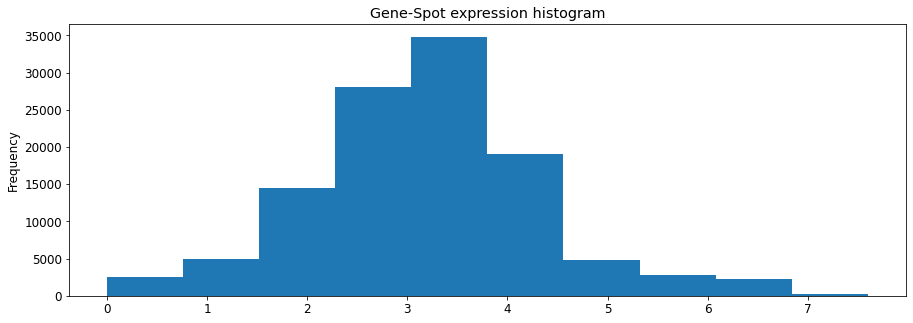

In [9]:
plt.figure(figsize=(15, 5))
df_expressions.loc[df_expressions['expression'] < 10, 'expression'].plot.hist(bins=10)
plt.title('Gene-Spot expression histogram')
plt.show()

## Encode Genes and Spots 

In [10]:
# Ordinal encoding the genes and spots for supported type
oe_genes = OrdinalEncoder()
df_expressions[['gene']] = oe_genes.fit_transform(df_expressions[['gene']].values)
oe_spots = OrdinalEncoder()
df_expressions[['spot']] = oe_spots.fit_transform(df_expressions[['spot']].values)

df_expressions[['spot', 'gene']] = df_expressions[['spot', 'gene']].astype(int)
df_expressions.head()

,spot,gene,expression
0,0,56,0.000000
1,0,15,0.000000
2,0,23,0.693147
3,0,4,1.098612
4,0,36,2.197225


# Train Test Split 

In [11]:
def plot_datasets_distribution(df_train, df_valid, df_test):
    print(f'Split to train, valid, and test:\nTrain shape:{df_train.shape}\nValid shape:{df_valid.shape}\nTest shape:{df_test.shape}')
    f, axs = plt.subplots(1, 3, figsize=(19, 5), sharey=True, sharex=True)
    df_train.loc[df_train['expression'] < 10, 'expression'].value_counts(normalize=True).sort_index().plot.bar(ax=axs[0])
    df_valid.loc[df_valid['expression'] < 10, 'expression'].value_counts(normalize=True).sort_index().plot.bar(ax=axs[1])
    df_test.loc[df_test['expression'] < 10, 'expression'].value_counts(normalize=True).sort_index().plot.bar(ax=axs[2])
    axs[0].set_title(f'Train Expression Dist | Avg Expression: {df_train["expression"].mean():.2f}')
    axs[1].set_title(f'Valid Expression Dist | Avg Expression: {df_valid["expression"].mean():.2f}')
    axs[2].set_title(f'Test Expression Dist | Avg Expression: {df_test["expression"].mean():.2f}')
    plt.show()

## Normal Random

In [12]:
df_train, df_test = train_test_split(df_expressions, test_size=0.10)
df_train, df_valid = train_test_split(df_train, test_size=0.10)

Split to train, valid, and test:
Train shape:(92145, 3)
Valid shape:(10239, 3)
Test shape:(11376, 3)


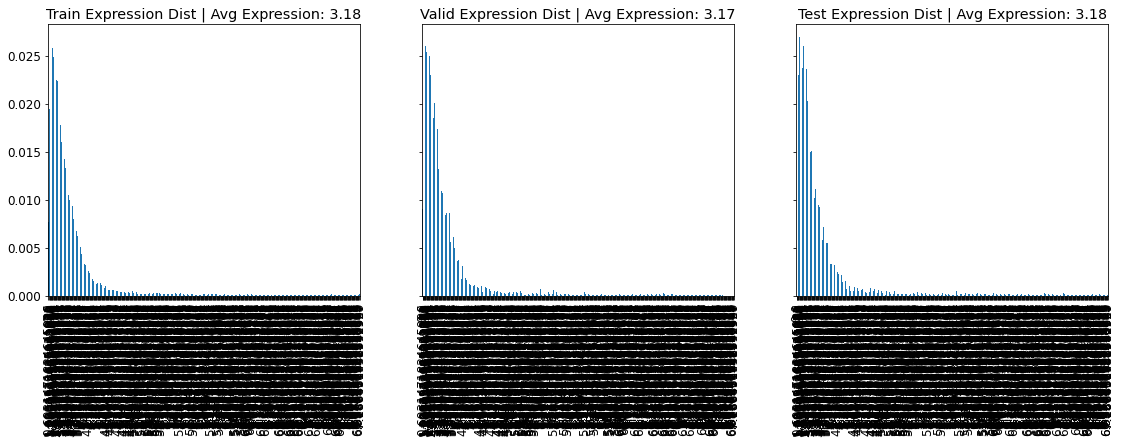

We can see that the train, valid and test datasets share the same expression distribution


In [13]:
plot_datasets_distribution(df_train, df_valid, df_test)
print('We can see that the train, valid and test datasets share the same expression distribution')

# Create Pytorch Data Loaders

In [18]:
batch_size = 128

## Generate DataSets 

In [19]:
class ExpressionDataset(Dataset):
    """
    Generate expression dataset to use in the our models, where each sample should be a tuple of (gene, spot, expression)
    """

    def __init__(self, df, device):
        self.num_samples = len(df)
        self.genes = tensor(df['gene'].values).to(device)
        self.spots = tensor(df['spot'].values).to(device)
        self.labels = tensor(df['expression'].values)
        self.num_genes = df['gene'].max()
        self.num_spots = df['spot'].max()

    def __getitem__(self, index):
        gene = self.genes[index]
        spot = self.spots[index]
        label = self.labels[index].item()
        return gene, spot, label

    def __len__(self):
        return self.num_samples

    def get_all_data(self):
        return self.genes, self.spots, self.labels

In [20]:
ds_train = ExpressionDataset(df=df_train, device=device)
ds_valid = ExpressionDataset(df=df_valid, device=device)
ds_test = ExpressionDataset(df=df_test, device=device)

## DataSets to DataLoaders 

In [21]:
dl_train = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)
dl_valid = DataLoader(dataset=ds_valid, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=True)

# Load Model

In [22]:
dl_train_exp = dl_train
dl_valid_exp = dl_valid
dl_test_exp = dl_test

In [23]:
model_name='NMF'
params = {
    'learning_rate': 0.001,
    'optimizer': "SGD",
    'latent_dim': 10,
    'batch_size': batch_size
}

In [24]:
model = get_model(model_name=model_name, params=params, dl_train=dl_train_exp)

# Train Model 

In [25]:
max_epochs = 5
early_stopping = 4

## Load Optimizer 

In [26]:
optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
criterion = NON_ZERO_RMSELoss()

## Train

In [27]:
model, valid_loss = trainer.trainer(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion,
    max_epochs=max_epochs, 
    early_stopping=early_stopping, 
    dl_train=dl_train_exp, 
    dl_test=dl_valid_exp, 
    device=device, 
    dataset_name=dataset_name, 
    model_name=model_name
)

2022-06-30 13:00:50.917739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-30 13:00:50.917793: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training Results - Epoch[1] Avg loss: 4.57
Validation Results - Epoch[1] Avg loss: 4.60
Training Results - Epoch[2] Avg loss: 4.56
Validation Results - Epoch[2] Avg loss: 4.59
Training Results - Epoch[3] Avg loss: 4.56
Validation Results - Epoch[3] Avg loss: 4.59
Training Results - Epoch[4] Avg loss: 4.56
Validation Results - Epoch[4] Avg loss: 4.59
Training Results - Epoch[5] Avg loss: 4.55
Validation Results - Epoch[5] Avg loss: 4.58


In [30]:
train_res = 4.55
valid_res = 4.58
print(f'Train final results (after log transform) = {train_res}')
print(f'Train final results = {np.exp(train_res)}')
print(f'Valid final results (after log transform) = {valid_res}')
print(f'Valid final results = {np.exp(valid_res)}')

Train final results (after log transform) = 4.55
Train final results = 94.63240831492406
Valid final results (after log transform) = 4.58
Valid final results = 97.51439420705401


## Test 

In [31]:
test_loss = tester(
    model=model,
    dl_test=dl_test_exp,
    device=device
)
print(f'Test loss (after log transform) = {test_loss}')
print(f'Test loss = {np.exp(test_loss)}')

Test loss (after log transform) = 4.568791077126585
Test loss = 96.4274659111692


## Reconstruction of the train matrix

In [46]:
all_gens = []
all_spots = []
expressions_train = []
log_transform = True

for set_dl in [dl_train_exp, dl_valid_exp, dl_test_exp]:
    for batch in set_dl:
        gens, spots, y = batch
        gens.to(device)
        spots.to(device)
        
        if log_transform:
                y = torch.exp(y)

        all_gens.extend(gens.tolist())
        all_spots.extend(spots.tolist())
        if (set_dl == dl_valid_exp) or (set_dl == dl_test_exp):
            y_zeros = torch.zeros(size=y.shape)
            expressions_train.extend(y_zeros.tolist())
        else:
            expressions_train.extend(y.tolist())

In [47]:
df_expressions_train = pd.DataFrame({'gene': all_gens, 'spot': all_spots, 'expression': expressions_train})
df_expressions_train[['gene']] = oe_genes.inverse_transform(df_expressions_train[['gene']].values)
df_expressions_train[['spot']] = oe_spots.inverse_transform(df_expressions_train[['spot']].values)

In [53]:
df_expressions_train_matrix = df_expressions_train.pivot(index='spot', columns='gene', values='expression')

In [54]:
new_obj_train = deepcopy(obj)
tmp_genes_locations = [obj.var.index.get_loc(key=gene_key) for gene_key in df_expressions_train_matrix.columns]

In [55]:
# Replace the values
new_obj_train.X[:, tmp_genes_locations] = df_expressions_train_matrix.values

/usr/local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Clustering The Train Dataset

In [56]:
st.pp.normalize_total(new_obj_train)
st.pp.log1p(new_obj_train)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


In [57]:
# run PCA for gene expression data
st.em.run_pca(new_obj_train, n_comps=50)
# K-means clustering
st.tl.clustering.kmeans(new_obj_train, n_clusters=7, use_data="X_pca", key_added="X_pca_kmeans")

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


In [ ]:
colors_map_dict = {
    '#1f77b4': 1, # Blue
    '#f87f13': 0, # Orange
    '#359c62': 3, # Green
    '#d32929': 4, # Red
    '#69308e': 5, # Purple
    '#8c564c': 6, # Brown
    '#f33ca9': 2  # Pink
}
clusters_colors = [c[0] for c in sorted(colors_map_dict.items(), key=lambda i: i[1])]

In [ ]:
new_obj_train.uns['X_pca_kmeans_colors'] = clusters_colors

<Figure size 432x288 with 0 Axes>

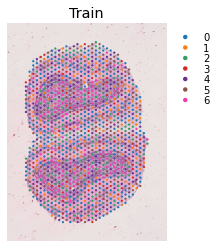

In [58]:
f = plt.figure()
st.pl.cluster_plot(new_obj_train, use_label="X_pca_kmeans")
plt.title('Train')
plt.show()

## Reconstruction of the whole matrix

In [72]:
model = model.to(device)
model.eval()

all_gens = []
all_spots = []
expressions_pred = []
expressions_true = []
log_transform = True

with torch.no_grad():
    for set_dl in [dl_train_exp, dl_valid_exp, dl_test_exp]:
        for batch in set_dl:
            gens, spots, y = batch
            gens.to(device)
            spots.to(device)
            y_pred = model(gens, spots)
            
            if log_transform:
                y = torch.exp(y)
                y_pred = torch.exp(y_pred)
            
            y_pred = np.clip(a=y_pred, a_min=0, a_max=None)
                
            all_gens.extend(gens.tolist())
            all_spots.extend(spots.tolist())
            expressions_pred.extend(y_pred.tolist())
            expressions_true.extend(y.tolist())

In [73]:
df_expressions_preds = pd.DataFrame({'gene': all_gens, 'spot': all_spots, 'expression': expressions_pred})
df_expressions_preds[['gene']] = oe_genes.inverse_transform(df_expressions_preds[['gene']].values)
df_expressions_preds[['spot']] = oe_spots.inverse_transform(df_expressions_preds[['spot']].values)

In [74]:
df_expressions_true = df_expressions_preds.copy()
df_expressions_true['expression'] = expressions_true

In [75]:
df_expressions_preds_matrix = df_expressions_preds.pivot(index='spot', columns='gene', values='expression')
df_expressions_true_matrix = df_expressions_true.pivot(index='spot', columns='gene', values='expression')

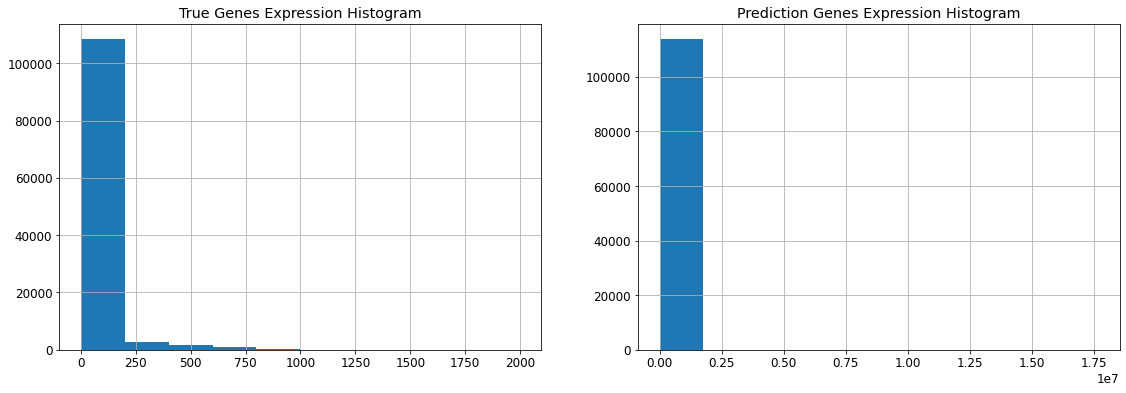

In [76]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 6))
df_expressions_true.expression.hist(ax=ax1)
df_expressions_preds.expression.hist(ax=ax2)
ax1.set_title('True Genes Expression Histogram')
ax2.set_title('Prediction Genes Expression Histogram')
plt.show()

In [77]:
new_obj = deepcopy(obj)
tmp_genes_locations = [obj.var.index.get_loc(key=gene_key) for gene_key in df_expressions_true_matrix.columns]

In [78]:
# Replace the values
new_obj.X[:, tmp_genes_locations] = df_expressions_preds_matrix.values

/usr/local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Gene: mt-Co1


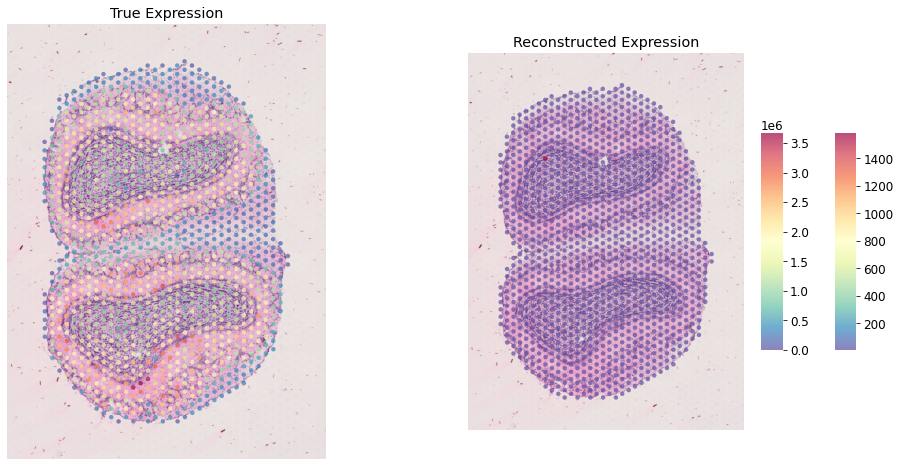

Gene: mt-Co3


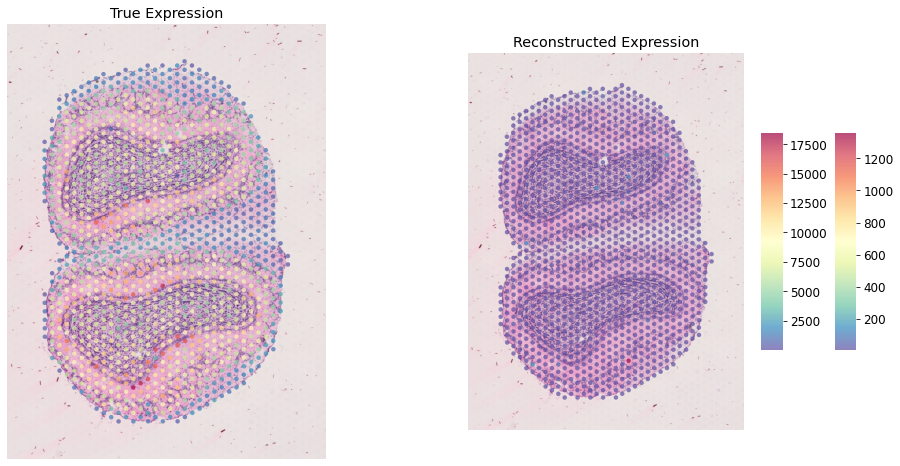

Gene: mt-Atp6


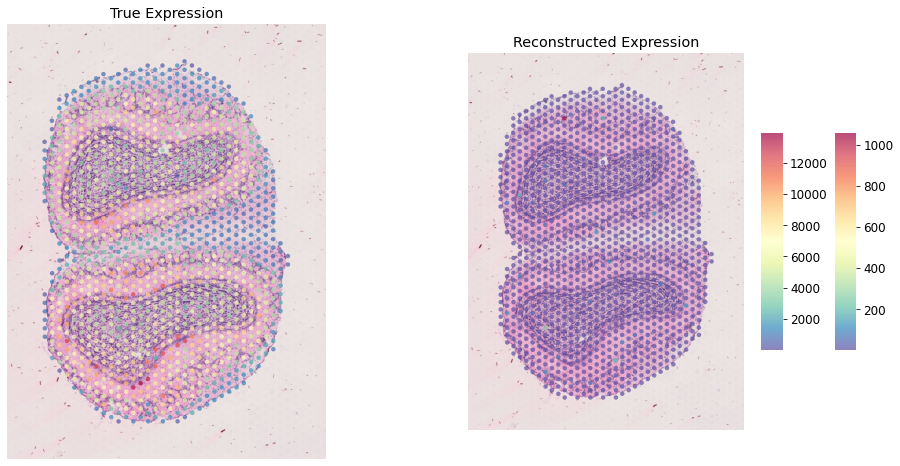

Gene: mt-Co2


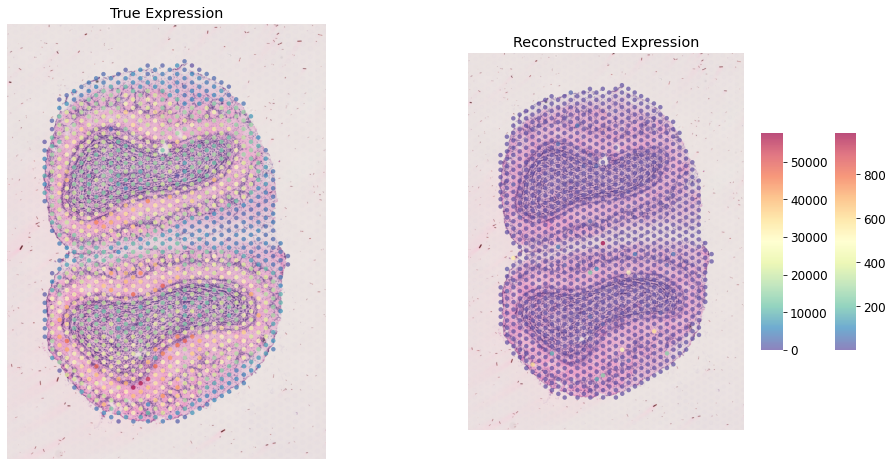

Gene: mt-Cytb


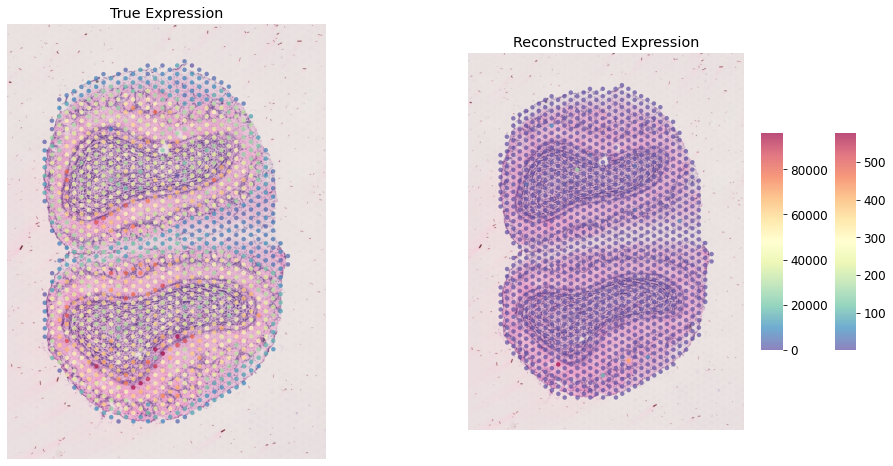

In [79]:
for gene_symbol in top_genes_names[:5]:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))
    st.pl.gene_plot(obj, gene_symbols=gene_symbol, size=20, ax=ax1)
    ax1.set_title('True Expression')
    st.pl.gene_plot(new_obj, gene_symbols=gene_symbol, size=20, ax=ax2)
    ax2.set_title('Reconstructed Expression')
    print(f'Gene: {gene_symbol}')
    plt.show()

## Clustering Full Reconstructed

In [80]:
new_obj_clusters = deepcopy(new_obj)

In [81]:
st.pp.normalize_total(new_obj_clusters)
st.pp.log1p(new_obj_clusters)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


In [82]:
# run PCA for gene expression data
st.em.run_pca(new_obj_clusters, n_comps=50)
# K-means clustering
st.tl.clustering.kmeans(new_obj_clusters, n_clusters=7, use_data="X_pca", key_added="X_pca_kmeans")

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


In [ ]:
colors_map_dict = {
    '#1f77b4': 1, # Blue
    '#f87f13': 0, # Orange
    '#359c62': 3, # Green
    '#d32929': 4, # Red
    '#69308e': 5, # Purple
    '#8c564c': 6, # Brown
    '#f33ca9': 2  # Pink
}
clusters_colors = [c[0] for c in sorted(colors_map_dict.items(), key=lambda i: i[1])]

In [ ]:
new_obj_train.uns['X_pca_kmeans_colors'] = clusters_colors

Text(0.5, 1.0, 'Reconstructed')

<Figure size 432x288 with 0 Axes>

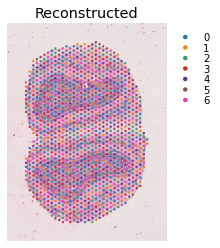

In [84]:
f = plt.figure()
st.pl.cluster_plot(new_obj_clusters, use_label="X_pca_kmeans")
plt.title('Reconstructed')